In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import math
from random import choices
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from jsonlines import jsonlines
from typing import Dict, List, Any
from matplotlib import pyplot as plt
import evaluate
from datetime import datetime

from src.settings import PREPROCESSED_DIR, MODELS_DIR, LOGS_DIR

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
DEVICE

device(type='cuda')

In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [4]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    # return torch.device('cpu')

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled = scaled.permute(1, 0, 2, 3) + mask
        scaled = scaled.permute(1, 0, 2, 3)
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        even_i = torch.arange(0, self.d_model, 2).float()
        denominator = torch.pow(10000, even_i/self.d_model)
        position = (torch.arange(self.max_sequence_length)
                          .reshape(self.max_sequence_length, 1))
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        return PE

class SentenceEmbedding(nn.Module):
    "For a given sentence, create an embedding"
    def __init__(self, max_sequence_length, d_model, vocab_size):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.position_encoder = PositionalEncoding(d_model, max_sequence_length)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x): # batched tokens ids
        x = self.embedding(x)
        pos = self.position_encoder().to(get_device())
        x = self.dropout(x + pos)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask):
        batch_size, sequence_length, d_model = x.size()
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        values, attention = scaled_dot_product(q, k, v, mask)
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        out = self.linear_layer(values)
        return out


class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim=dims, keepdim=True)
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt()
        y = (inputs - mean) / std
        out = self.gamma * y + self.beta
        return out

  
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x


class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, self_attention_mask):
        residual_x = x.clone()
        x = self.attention(x, mask=self_attention_mask)
        x = self.dropout1(x)
        x = self.norm1(x + residual_x)
        residual_x = x.clone()
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + residual_x)
        return x
    
class SequentialEncoder(nn.Sequential):
    def forward(self, *inputs):
        x, self_attention_mask  = inputs
        for module in self._modules.values():
            x = module(x, self_attention_mask)
        return x

class FrameLandmarksEmbedding(nn.Module):
    "For a given sentence, create an embedding"
    def __init__(self, max_frames, d_model, n_landmarks=99):
        super().__init__()
        self.max_sequence_length = max_frames
        self.linear = nn.Linear(n_landmarks, d_model)
        self.position_encoder = PositionalEncoding(d_model, self.max_sequence_length)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):  # seq of frames (landmarks), batched
        # in: (batch_size, n_frames, 99)
        # x = x[:, :self.max_sequence_length, :]
        # x = F.pad(x, (0, 0, 0, self.max_sequence_length - x.size(1)), value=-1)
        x = self.linear(x)
        pos = self.position_encoder().to(get_device())
        x = self.dropout(x + pos)
        # out: (batch_size, max_sequence_length, d_model)
        return x

class Encoder(nn.Module):
    def __init__(self, 
                 d_model, 
                 ffn_hidden, 
                 num_heads, 
                 drop_prob, 
                 num_layers,
                 max_sequence_length
                ):
        super().__init__()
        # self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.frames_seq_embedding = FrameLandmarksEmbedding(max_sequence_length, d_model)
        self.layers = SequentialEncoder(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                      for _ in range(num_layers)])

    def forward(self, x, self_attention_mask):
        # x = self.sentence_embedding(x, start_token, end_token)
        x = self.frames_seq_embedding(x)
        x = self.layers(x, self_attention_mask)
        return x


class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model)
        self.q_layer = nn.Linear(d_model , d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, y, mask):
        batch_size, sequence_length, d_model = x.size() # in practice, this is the same for both languages...so we can technically combine with normal attention
        kv = self.kv_layer(x)
        q = self.q_layer(y)
        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim)
        kv = kv.permute(0, 2, 1, 3)
        q = q.permute(0, 2, 1, 3)
        k, v = kv.chunk(2, dim=-1)
        values, attention = scaled_dot_product(q, k, v, mask) # We don't need the mask for cross attention, removing in outer function!
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, d_model)
        out = self.linear_layer(values)
        return out


class DecoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.layer_norm3 = LayerNormalization(parameters_shape=[d_model])
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, x, y, self_attention_mask, cross_attention_mask):
        _y = y.clone()
        y = self.self_attention(y, mask=self_attention_mask)
        y = self.dropout1(y)
        y = self.layer_norm1(y + _y)

        _y = y.clone()
        y = self.encoder_decoder_attention(x, y, mask=cross_attention_mask)
        y = self.dropout2(y)
        y = self.layer_norm2(y + _y)

        _y = y.clone()
        y = self.ffn(y)
        y = self.dropout3(y)
        y = self.layer_norm3(y + _y)
        return y


class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs):
        x, y, self_attention_mask, cross_attention_mask = inputs
        for module in self._modules.values():
            y = module(x, y, self_attention_mask, cross_attention_mask)
        return y

class Decoder(nn.Module):
    def __init__(self, 
                 d_model, 
                 ffn_hidden, 
                 num_heads, 
                 drop_prob, 
                 num_layers,
                 max_sequence_length,
                 vocab_size,
                ):
        super().__init__()
        self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, vocab_size)
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob) for _ in range(num_layers)])

    def forward(self, x, y, self_attention_mask, cross_attention_mask):
        y = self.sentence_embedding(y)
        y = self.layers(x, y, self_attention_mask, cross_attention_mask)
        return y


class Transformer(nn.Module):
    def __init__(self, 
        d_model, 
        ffn_hidden, 
        num_heads, 
        drop_prob, 
        num_layers,
        max_sequence_length, 
        vocab_size,
    ):
        super().__init__()
        self.encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length)
        self.decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, vocab_size)
        self.linear = nn.Linear(d_model, vocab_size)

    def forward(self, 
                x, 
                y, 
                encoder_self_attention_mask=None, 
                decoder_self_attention_mask=None, 
                decoder_cross_attention_mask=None,
    ):
        x = self.encoder(x, encoder_self_attention_mask)
        out = self.decoder(x, y, decoder_self_attention_mask, decoder_cross_attention_mask)
        out = self.linear(out)
        return out

In [5]:
NUM_HEADS = 8
DROP_PROB = 0.1
NUM_LAYERS = 5
D_MODEL = 512
FFN_HIDDEN = 2048

MAX_SEQUENCE_LENGTH = 50  # max in frames = max out tokens
N_LANDMARKS = 99
VOCAB_SIZE = 50_000

BATCH_SIZE = 32
SAMPLE_FRAC = 1

In [6]:
class ClipsDataset(Dataset):

    def __init__(self, records: List[Dict[str, Any]], max_input_lenght, max_output_length):
        self.records = records
        self.max_input_lenght = max_input_lenght
        self.max_output_length = max_output_length

    def __len__(self) -> int:
        return len(self.records)

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        out_polish_token_ids = torch.tensor(self.records[index]["PolishAnnotationTokenIds"], dtype=torch.int32)
        if len(out_polish_token_ids) > 66:
            # FIXME: this is a hack to make it work with the model; only one clip is affected
            print("Warning: PolishAnnotationTokenIds is longer than 66")
            out_polish_token_ids = out_polish_token_ids[:66]

        out_polish_token_ids = out_polish_token_ids[:self.max_output_length]

        # (seq_len x 33 x 3) -> (seq_len x 99)
        frame_seq_landmarks = torch.tensor(self.records[index]["FramesLandmarksCoords"], dtype=torch.float32).view(-1, 99)
        every_nth_frame_seq_landmarks = frame_seq_landmarks[::4]  # get every 4th frame
        seq_pad_len = self.max_input_lenght - every_nth_frame_seq_landmarks.size(0)
        padded_frame_seq_landmarks = F.pad(every_nth_frame_seq_landmarks, (0, 0, 0, seq_pad_len), value=0)  # 200x99
        # prepro_landmarks_seq = self.preprocess_landmarks_seq(frame_seq_landmarks)

        return {
            "in_landmarks": padded_frame_seq_landmarks,
            "out_polish_token_ids": out_polish_token_ids,
        }

In [7]:
with jsonlines.open(PREPROCESSED_DIR / "clips_dataset_wth_herbert_token_ids.jsonl") as reader:
    # total_records: 19_503
    if SAMPLE_FRAC < 1:
        raw_records = list((rec for rec in reader if np.random.choice([True, False], p=[SAMPLE_FRAC, 1 - SAMPLE_FRAC])))  # iterable approach for random sample
    else:
        raw_records = list(reader)

train_records, val_records = train_test_split(raw_records, test_size=0.2)

In [8]:
train_ds = ClipsDataset(train_records, max_input_lenght=MAX_SEQUENCE_LENGTH, max_output_length=MAX_SEQUENCE_LENGTH)
val_ds = ClipsDataset(val_records, max_input_lenght=MAX_SEQUENCE_LENGTH, max_output_length=MAX_SEQUENCE_LENGTH)

# del train_records, val_records, raw_records

len(train_ds), len(val_ds)

(15602, 3901)

In [9]:
for record in train_ds:
    print(record["in_landmarks"].shape)  # n_frames x n_landmarks*3
    print(record["out_polish_token_ids"].shape)  # padded n_tokens
    break

torch.Size([50, 99])
torch.Size([50])


In [10]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, pin_memory=True)

In [11]:
for record in train_dl:
    print(record["in_landmarks"].shape)  # n_frames x n_landmarks*3
    print(record["out_polish_token_ids"].shape)  # padded n_tokens
    print(record["out_polish_token_ids"][0])
    break

torch.Size([32, 50, 99])
torch.Size([32, 50])
tensor([    0,    57,  2542,    80, 12070, 14986,  2099,  2334,  1899,     2,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
       dtype=torch.int32)


In [12]:
NEG_INFTY = -1e9

def create_masks(seq_landmarks_batch, token_ids_batch):
    num_sentences = len(seq_landmarks_batch)
    look_ahead_mask = torch.full([MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH] , True)
    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1)
    encoder_padding_mask = torch.full([num_sentences, MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH] , False)
    decoder_padding_mask_self_attention = torch.full([num_sentences, MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH] , False)
    decoder_padding_mask_cross_attention = torch.full([num_sentences, MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH] , False)

    for idx in range(num_sentences):
      seq_landmarks_len = len(seq_landmarks_batch[idx])
      seq_token_ids_len = len(token_ids_batch[idx])
      seq_landmarks_pad_mask_ids = np.arange(seq_landmarks_len + 1, MAX_SEQUENCE_LENGTH)
      seq_token_ids_pad_mask_ids = np.arange(seq_token_ids_len + 1, MAX_SEQUENCE_LENGTH)
      encoder_padding_mask[idx, :, seq_landmarks_pad_mask_ids] = True
      encoder_padding_mask[idx, seq_landmarks_pad_mask_ids, :] = True
      decoder_padding_mask_self_attention[idx, :, seq_token_ids_pad_mask_ids] = True
      decoder_padding_mask_self_attention[idx, seq_token_ids_pad_mask_ids, :] = True
      decoder_padding_mask_cross_attention[idx, :, seq_landmarks_pad_mask_ids] = True
      decoder_padding_mask_cross_attention[idx, seq_token_ids_pad_mask_ids, :] = True

    encoder_self_attention_mask = torch.where(encoder_padding_mask, NEG_INFTY, 0)
    decoder_self_attention_mask =  torch.where(look_ahead_mask + decoder_padding_mask_self_attention, NEG_INFTY, 0)
    decoder_cross_attention_mask = torch.where(decoder_padding_mask_cross_attention, NEG_INFTY, 0)
    return encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask

In [13]:
def train_step(x, y, model, tokenizer, criterion, optim):
    model.train()
    optim.zero_grad()

    encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(x, y)

    prediction = model(x, y, encoder_self_attention_mask.to(DEVICE),  decoder_self_attention_mask.to(DEVICE), decoder_cross_attention_mask.to(DEVICE))

    criterion_input = prediction.view(-1, VOCAB_SIZE)
    criterion_target = y.view(-1).long()
    loss = criterion(criterion_input, criterion_target)

    valid_indicies = torch.where(criterion_target.view(-1) == tokenizer.pad_token_id, False, True)
    loss = loss.sum() / valid_indicies.sum()

    loss.backward()
    optim.step()

    return loss.item()


def eval_step(x, y, model, tokenizer, criterion):
    model.eval()

    encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(x, y)

    with torch.no_grad():
        prediction = model(x, y, encoder_self_attention_mask.to(DEVICE),  decoder_self_attention_mask.to(DEVICE), decoder_cross_attention_mask.to(DEVICE))

        criterion_input = prediction.view(-1, VOCAB_SIZE)
        criterion_target = y.view(-1).long()
        loss = criterion(criterion_input, criterion_target)

        valid_indicies = torch.where(criterion_target.view(-1) == tokenizer.pad_token_id, False, True)
        loss = loss.sum() / valid_indicies.sum()

    return prediction, loss.item()

In [14]:
EPOCHS = 30
LEARNING_RATE = 1e-4

In [15]:
transformer = Transformer(
    d_model=D_MODEL,
    ffn_hidden=FFN_HIDDEN,
    num_heads=NUM_HEADS,
    drop_prob=DROP_PROB,
    num_layers=NUM_LAYERS,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    vocab_size=VOCAB_SIZE,
).to(DEVICE)

tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
tokenizer.pad_token_id = 1
tokenizer.bos_token_id = 0
tokenizer.eos_token_id = 2

print(f"{tokenizer.vocab_size=}")

tokenizer.vocab_size=50000


In [16]:
meteor_model = evaluate.load("meteor")
bertscore_model = evaluate.load("bertscore")
ter_model = evaluate.load("ter")
sacrebleu = evaluate.load("sacrebleu")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [17]:
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, reduction="none")
optim = torch.optim.Adam(transformer.parameters(), lr=LEARNING_RATE)

In [18]:
n_train_batches = len(train_dl)
n_val_batches = len(val_dl)

metrics_history = []
for epoch in range(EPOCHS):
    print(f" Epoch {epoch} ".center(80, "-"))
    
    epoch_metrics = {
        "Epoch": epoch + 1,
        "TrainLoss": 0,
        "ValLoss": 0,
        "ValMETEOR": 0,
        "ValBERTScoreAvgF1": 0,
        "ValBERTScoreAvgPrecision": 0,
        "ValBERTScoreAvgRecall": 0,
        "ValTER": 0,
        "ValBLEU": 0,
    }

    # Epoch Training
    for batch_num, (train_batch, val_batch) in enumerate(zip(train_dl, val_dl)):
        x_train, y_train = train_batch["in_landmarks"].to(DEVICE), train_batch["out_polish_token_ids"].to(DEVICE)
        train_loss = train_step(x_train, y_train, transformer, tokenizer, criterion, optim)

        epoch_metrics["TrainLoss"] += train_loss / n_train_batches

    # Epoch Validation
    for batch_num, val_batch in enumerate(val_dl):
        x_val, y_val = val_batch["in_landmarks"].to(DEVICE), val_batch["out_polish_token_ids"].to(DEVICE)
        val_pred, val_loss = eval_step(x_val, y_val, transformer, tokenizer, criterion)
        
        y_batch_decoded = tokenizer.batch_decode(y_val, skip_special_tokens=True)
        val_ids_predictions = torch.argmax(val_pred, dim=-1)
        val_pred_decoded = tokenizer.batch_decode(val_ids_predictions, skip_special_tokens=True)

        meteor_score = meteor_model.compute(
            predictions=val_pred_decoded,
            references=y_batch_decoded,
        )
        bert_score = bertscore_model.compute(
            predictions=val_pred_decoded,
            references=y_batch_decoded,
            lang="pl"
        )
        ter_score = ter_model.compute(
            predictions=val_pred_decoded,
            references=y_batch_decoded,
        )
        bleu_score = sacrebleu.compute(
            predictions=val_pred_decoded,
            references=y_batch_decoded,
        )

        epoch_metrics["ValLoss"] += val_loss / n_val_batches
        epoch_metrics["ValMETEOR"] += meteor_score["meteor"] / n_val_batches
        epoch_metrics["ValBERTScoreAvgF1"] += np.mean(bert_score["f1"]) / n_val_batches
        epoch_metrics["ValBERTScoreAvgPrecision"] += np.mean(bert_score["precision"]) / n_val_batches
        epoch_metrics["ValBERTScoreAvgRecall"] += np.mean(bert_score["recall"]) / n_val_batches
        epoch_metrics["ValTER"] += ter_score["score"] / n_val_batches
        epoch_metrics["ValBLEU"] += bleu_score["score"] / n_val_batches

        if batch_num % 100 == 0:
            print(f"Iteration {batch_num}  |  TrainLoss: {train_loss:.4f} ValLoss: {val_loss:.4f}")
            print((
                f"ValMETEOR: {meteor_score['meteor']:.4f}"
                f" ValBERTScoreAvgF1: {np.mean(bert_score['f1']):.4f}"
                f" ValBERTScoreAvgPrecision: {np.mean(bert_score['precision']):.4f}"
                f" ValBERTScoreAvgRecall: {np.mean(bert_score['recall']):.4f}"
                f" ValTER: {ter_score['score']:.4f}"
                f" ValBLEU: {bleu_score['score']:.4f}"
            ))
            for i in choices(range(BATCH_SIZE), k=3):
                print(f"Polish Annotation: {y_batch_decoded[i]}")
                print(f"Prediction (Val): {val_pred_decoded[i]}")
                print()

    metrics_history.append(epoch_metrics)


----------------------------------- Epoch 0 ------------------------------------
Iteration 0  |  TrainLoss: 3.5965 ValLoss: 3.2821
ValMETEOR: 0.4161 ValBERTScoreAvgF1: 0.6529 ValBERTScoreAvgPrecision: 0.6366 ValBERTScoreAvgRecall: 0.6718 ValTER: 166.8421 ValBLEU: 10.2989
Polish Annotation: Trzech chłopców przyszło pomóc zbierać gruszki.
Prediction (Val): i.. Nie z gruszki. się się się się się się się się się z

Polish Annotation: Spiłować drzewo to znaczy niszczyć.
Prediction (Val): piłować w to znaczy to. się się się się się się się się z

Polish Annotation: A tak, pociag.
Prediction (Val): A tak, to? i. się się się się się się z

Iteration 100  |  TrainLoss: 3.5965 ValLoss: 2.9294
ValMETEOR: 0.4327 ValBERTScoreAvgF1: 0.6572 ValBERTScoreAvgPrecision: 0.6303 ValBERTScoreAvgRecall: 0.6895 ValTER: 207.0968 ValBLEU: 10.9264
Polish Annotation: Aha.
Prediction (Val): Aha. się się się się się Jak Jak Jak się się

Polish Annotation: Tata boi się, bo jabłko jest małe.
Prediction (Val): do się,

In [19]:
metrics_df = pd.DataFrame.from_records(metrics_history)
metrics_df.to_csv(LOGS_DIR / f"transformer_train_eval_metrics__{datetime.now().strftime('%Y%m%d_%H%M%Sf%f')}.csv", index=False)
metrics_df

,Epoch,TrainLoss,ValLoss,ValMETEOR,ValBERTScoreAvgF1,ValBERTScoreAvgPrecision,ValBERTScoreAvgRecall,ValTER,ValBLEU
0,1,1.245996,3.193566,0.386290,0.650232,0.629535,0.674783,185.158756,9.913149
1,2,0.639864,2.132788,0.388298,0.582980,0.509373,0.688309,757.019034,5.858127
2,3,0.434843,1.658113,0.445399,0.601016,0.514653,0.730136,744.232008,7.589233
3,4,0.320652,1.381311,0.477854,0.621961,0.526609,0.764717,694.142811,9.010349
4,5,0.245203,1.199081,0.507100,0.600506,0.490945,0.779961,608.078973,10.704719
5,6,0.190571,1.074191,0.500373,0.597735,0.486334,0.781390,688.543104,9.950937
6,7,0.149388,0.984532,0.537838,0.598703,0.483951,0.790763,632.168551,11.184857
7,8,0.117429,0.918458,0.642538,0.645381,0.540958,0.804475,368.521498,18.101942
8,9,0.092471,0.868575,0.625106,0.643082,0.536035,0.808601,415.730742,16.589744
9,10,0.072400,0.830540,0.537022,0.617423,0.507032,0.794618,675.290887,11.011372


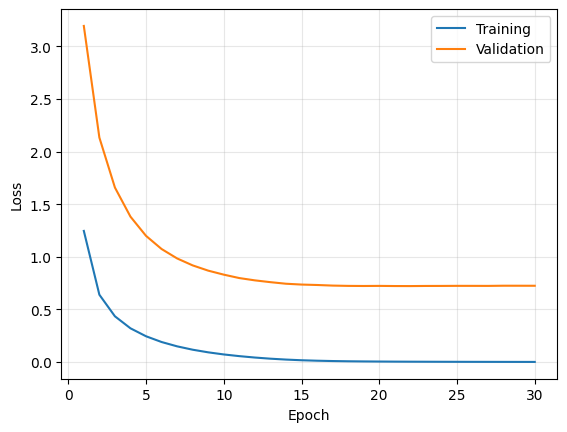

In [20]:
sns.lineplot(data=metrics_df, x="Epoch", y="TrainLoss", label="Training")
sns.lineplot(data=metrics_df, x="Epoch", y="ValLoss", label="Validation")
plt.grid(alpha=0.3)
plt.ylabel("Loss")
plt.show()

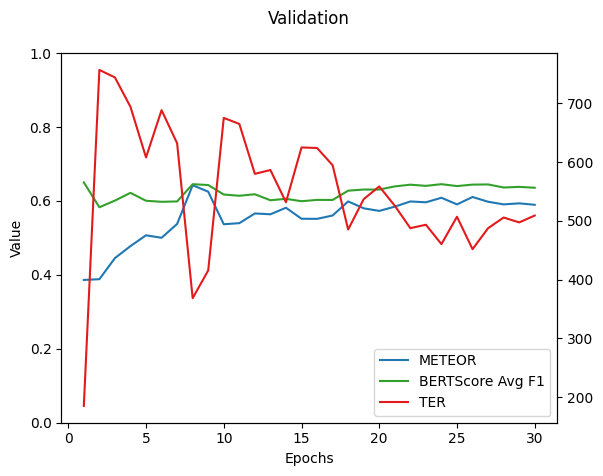

In [21]:
fig, ax1 = plt.subplots()

# Set the colors for the lines
color1 = sns.color_palette("Paired")[1]
color2 = sns.color_palette("Paired")[3]
color3 = sns.color_palette("Paired")[5]

# Plot the first two lines with the primary y-axis
sns.lineplot(
    data=metrics_df,
    x="Epoch",
    y="ValMETEOR",
    ax=ax1,
    label="METEOR",
    color=color1,
    legend=False,
)
sns.lineplot(
    data=metrics_df,
    x="Epoch",
    y="ValBERTScoreAvgF1",
    ax=ax1,
    label="BERTScore Avg F1",
    color=color2,
    legend=False,
)

# Create a second y-axis for the third line
ax2 = ax1.twinx()

sns.lineplot(
    data=metrics_df,
    x="Epoch",
    y="ValTER",
    ax=ax2,
    label="TER",
    color=color3,
)

# Set the labels for the y-axes
ax1.set_ylim(0, 1)
ax1.set_ylabel('Value')

# Set the label for the x-axis
ax1.set_xlabel('Epochs')
ax2.set_ylabel("")

# Add a legend for all lines
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower right')

plt.title('Validation\n')
plt.show()

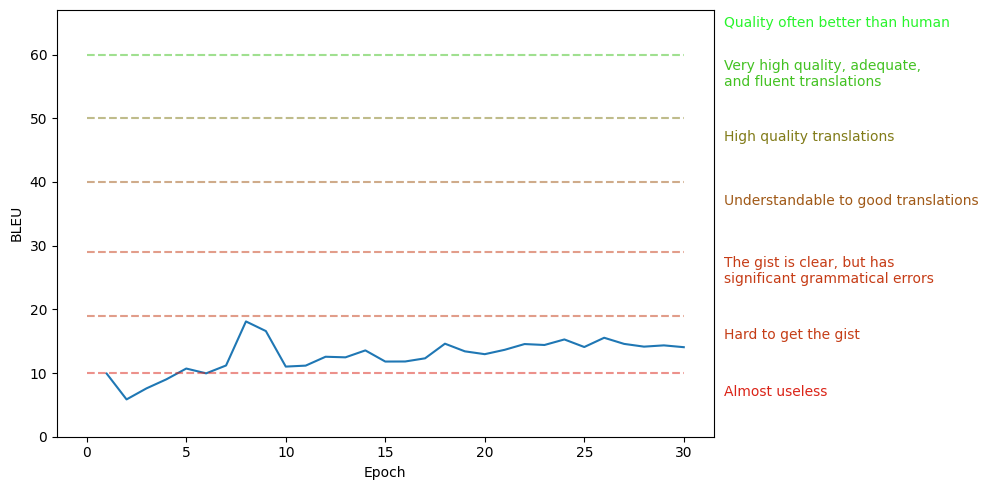

In [68]:
threshold_colors = ["#DB2418", "#C53D16", "#C63C16", "#A05917", "#817B18", "#43C222", "#29F52D"]
threshold_values = [10, 19, 29, 40, 50, 60, 65]
threshold_labels = [
    "Almost useless",
    "Hard to get the gist",
    "The gist is clear, but has\nsignificant grammatical errors",
    "Understandable to good translations",
    "High quality translations",
    "Very high quality, adequate,\nand fluent translations",
    "Quality often better than human",
]

plt.figure(figsize=(10, 5))
sns.lineplot(data=metrics_df, x="Epoch", y="ValBLEU")
plt.ylim(0, threshold_values[-1] + 2)
plt.ylabel("BLEU")

for threshold, color, label in zip(threshold_values, threshold_colors, threshold_labels):
    if threshold != 65:
        plt.hlines(threshold, 0, len(metrics_df), linestyles="--", colors=color, alpha=0.5)
    plt.text(len(metrics_df) + 2, (threshold - 3) if threshold != 65 else threshold, label, color=color, va="center")

plt.tight_layout()
plt.show()

In [22]:
torch.save(transformer.state_dict(), MODELS_DIR / "transformer_v1.pth")

In [23]:
total_params = sum(p.numel() for p in transformer.parameters())
trainable_params = sum(p.numel() for p in transformer.parameters() if p.requires_grad)

print(f"{total_params=:,}")
print(f"{trainable_params=:,}")

total_params=88,083,280
trainable_params=88,083,280


## Playground

In [24]:
assert False

AssertionError: 

In [ ]:
encoder = Encoder(
    d_model=D_MODEL,
    ffn_hidden=FFN_HIDDEN,
    num_heads=NUM_HEADS,
    drop_prob=DROP_PROB,
    num_layers=NUM_LAYERS,
    max_sequence_length=MAX_SEQUENCE_LENGTH
).to(DEVICE)

In [ ]:
x = torch.randn( (BATCH_SIZE, MAX_SEQUENCE_LENGTH, N_LANDMARKS) ).to(DEVICE) # includes positional encoding
out = encoder(x, self_attention_mask=None)

out.shape

In [ ]:
x = torch.randn( (BATCH_SIZE, MAX_SEQUENCE_LENGTH, D_MODEL) ).to(DEVICE)  # seq of frames (landmarks), batched; positional encoded
y = torch.randint(0, VOCAB_SIZE, (BATCH_SIZE, MAX_SEQUENCE_LENGTH) ).to(DEVICE)  # batched tokens ids; positional encoded

mask = torch.full([MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH] , float('-inf')).to(DEVICE)
mask = torch.triu(mask, diagonal=1).to(DEVICE)

decoder = Decoder(D_MODEL, FFN_HIDDEN, NUM_HEADS, DROP_PROB, NUM_LAYERS, MAX_SEQUENCE_LENGTH, VOCAB_SIZE).to(DEVICE)

out = decoder(x, y, mask, mask)

In [ ]:
out.shape

In [ ]:
transformer = Transformer(
    d_model=D_MODEL,
    ffn_hidden=FFN_HIDDEN,
    num_heads=NUM_HEADS,
    drop_prob=DROP_PROB,
    num_layers=NUM_LAYERS,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    vocab_size=VOCAB_SIZE,
).to(DEVICE)

In [ ]:
x = torch.randn( (BATCH_SIZE, MAX_SEQUENCE_LENGTH, N_LANDMARKS) ).to(get_device())
y = torch.randint(0, VOCAB_SIZE, (BATCH_SIZE, MAX_SEQUENCE_LENGTH) ).to(get_device())

result = transformer(x, y)

In [ ]:
result.shape

In [ ]:
result

In [ ]:
TOKENIZER = "allegro/herbert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER)
tokenizer.pad_token_id = 1
tokenizer.bos_token_id = 0
tokenizer.eos_token_id = 2

tokenizer.decode(2), tokenizer.eos_token_id, tokenizer.vocab_size

In [ ]:
import evaluate
from pprint import pprint

meteor_model = evaluate.load("meteor")
bertscore_model = evaluate.load("bertscore")
ter_model = evaluate.load("ter")
sacrebleu = evaluate.load("sacrebleu")

for batch in val_dl:
    y_val = batch["out_polish_token_ids"].to(DEVICE)
    decoded_y_val = tokenizer.batch_decode(y_val, skip_special_tokens=True)
    meteor_score = meteor_model.compute(
        predictions=decoded_y_val,
        references=decoded_y_val,
    )
    bert_score = bertscore_model.compute(
        predictions=decoded_y_val,
        references=decoded_y_val,
        lang="pl"
    )
    ter_score = ter_model.compute(
        predictions=decoded_y_val,
        references=decoded_y_val,
    )
    blue_score = sacrebleu.compute(
        predictions=decoded_y_val,
        references=decoded_y_val,
    )
    pprint(f"{meteor_score=}")
    pprint(f"{bert_score=}")
    pprint(f"{ter_score=}")
    pprint(f"{blue_score=}")
    break